# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from WSMBSS import *
from numba import njit
from IPython import display
import pylab as pl
import warnings
warnings.filterwarnings("ignore")
# np.random.seed(874)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Nonnegative_Antisparse_Copula'

# Source Generation and Mixing Scenario

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.00094269441359


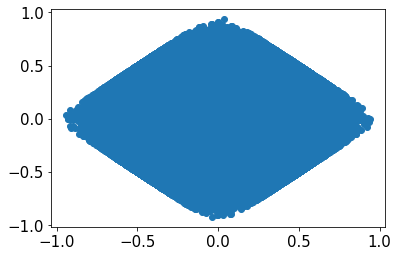

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10

S = 2*np.random.uniform(size = (NumberofSources,int(N)))-1
S = ProjectRowstoL1NormBall(S.T).T
INPUT_STD = 0.5

A,X = WSM_Mixing_Scenario(S, NumberofMixtures, INPUT_STD)

SNR=30
X, NoisePart = addWGN(X, SNR, return_noise = True)
SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

plt.scatter(S[0,:], S[2,:])
plt.show()

# Visualize Generated Sources and Mixtures

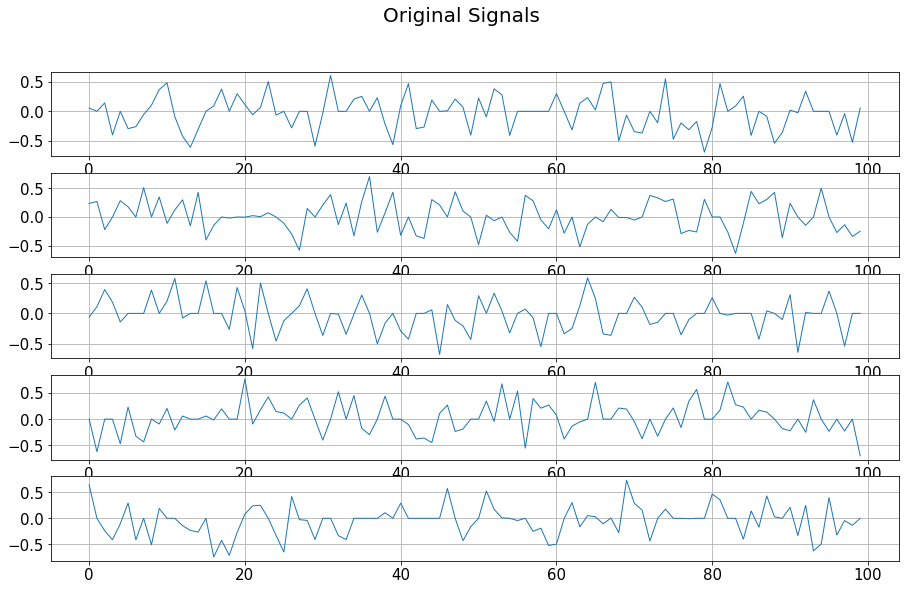

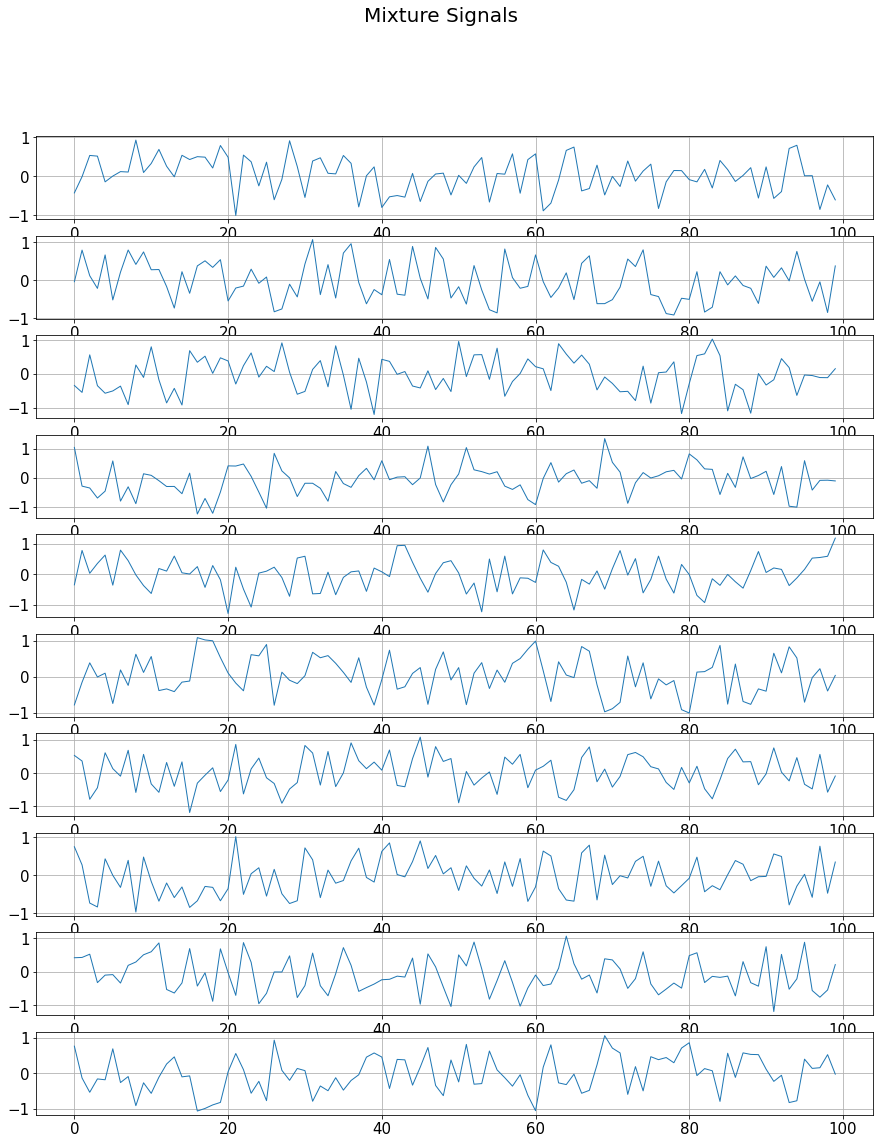

In [4]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
MUS = 0.25

gammaM_start = [MUS, MUS]
gammaM_stop = [1e-3, 1e-3]
gammaW_start = [MUS, MUS]
gammaW_stop = [1e-3, 1e-3]

OUTPUT_COMP_TOL = 1e-5
LayerGains = [8,1]
LayerMinimumGains = [1e-6,1]
LayerMaximumGains = [1e6,1.001]
WScalings = [0.0033,0.0033]
GamScalings = [0.02,0.02]
zeta = 1*1e-4
beta = 0.5
muD = [20, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
mixtures_power_normalized = True
# OPTIONS FOR synaptic_lr_rule: "constant", "divide_by_log_index", "divide_by_index"
synaptic_lr_rule = "divide_by_log_index" 
# OPTIONS FOR neural_loop_lr_rule: "constant", "divide_by_loop_index", "divide_by_slow_loop_index"
neural_loop_lr_rule = "constant"

# Run WSM Algorithm on Mixture Signals

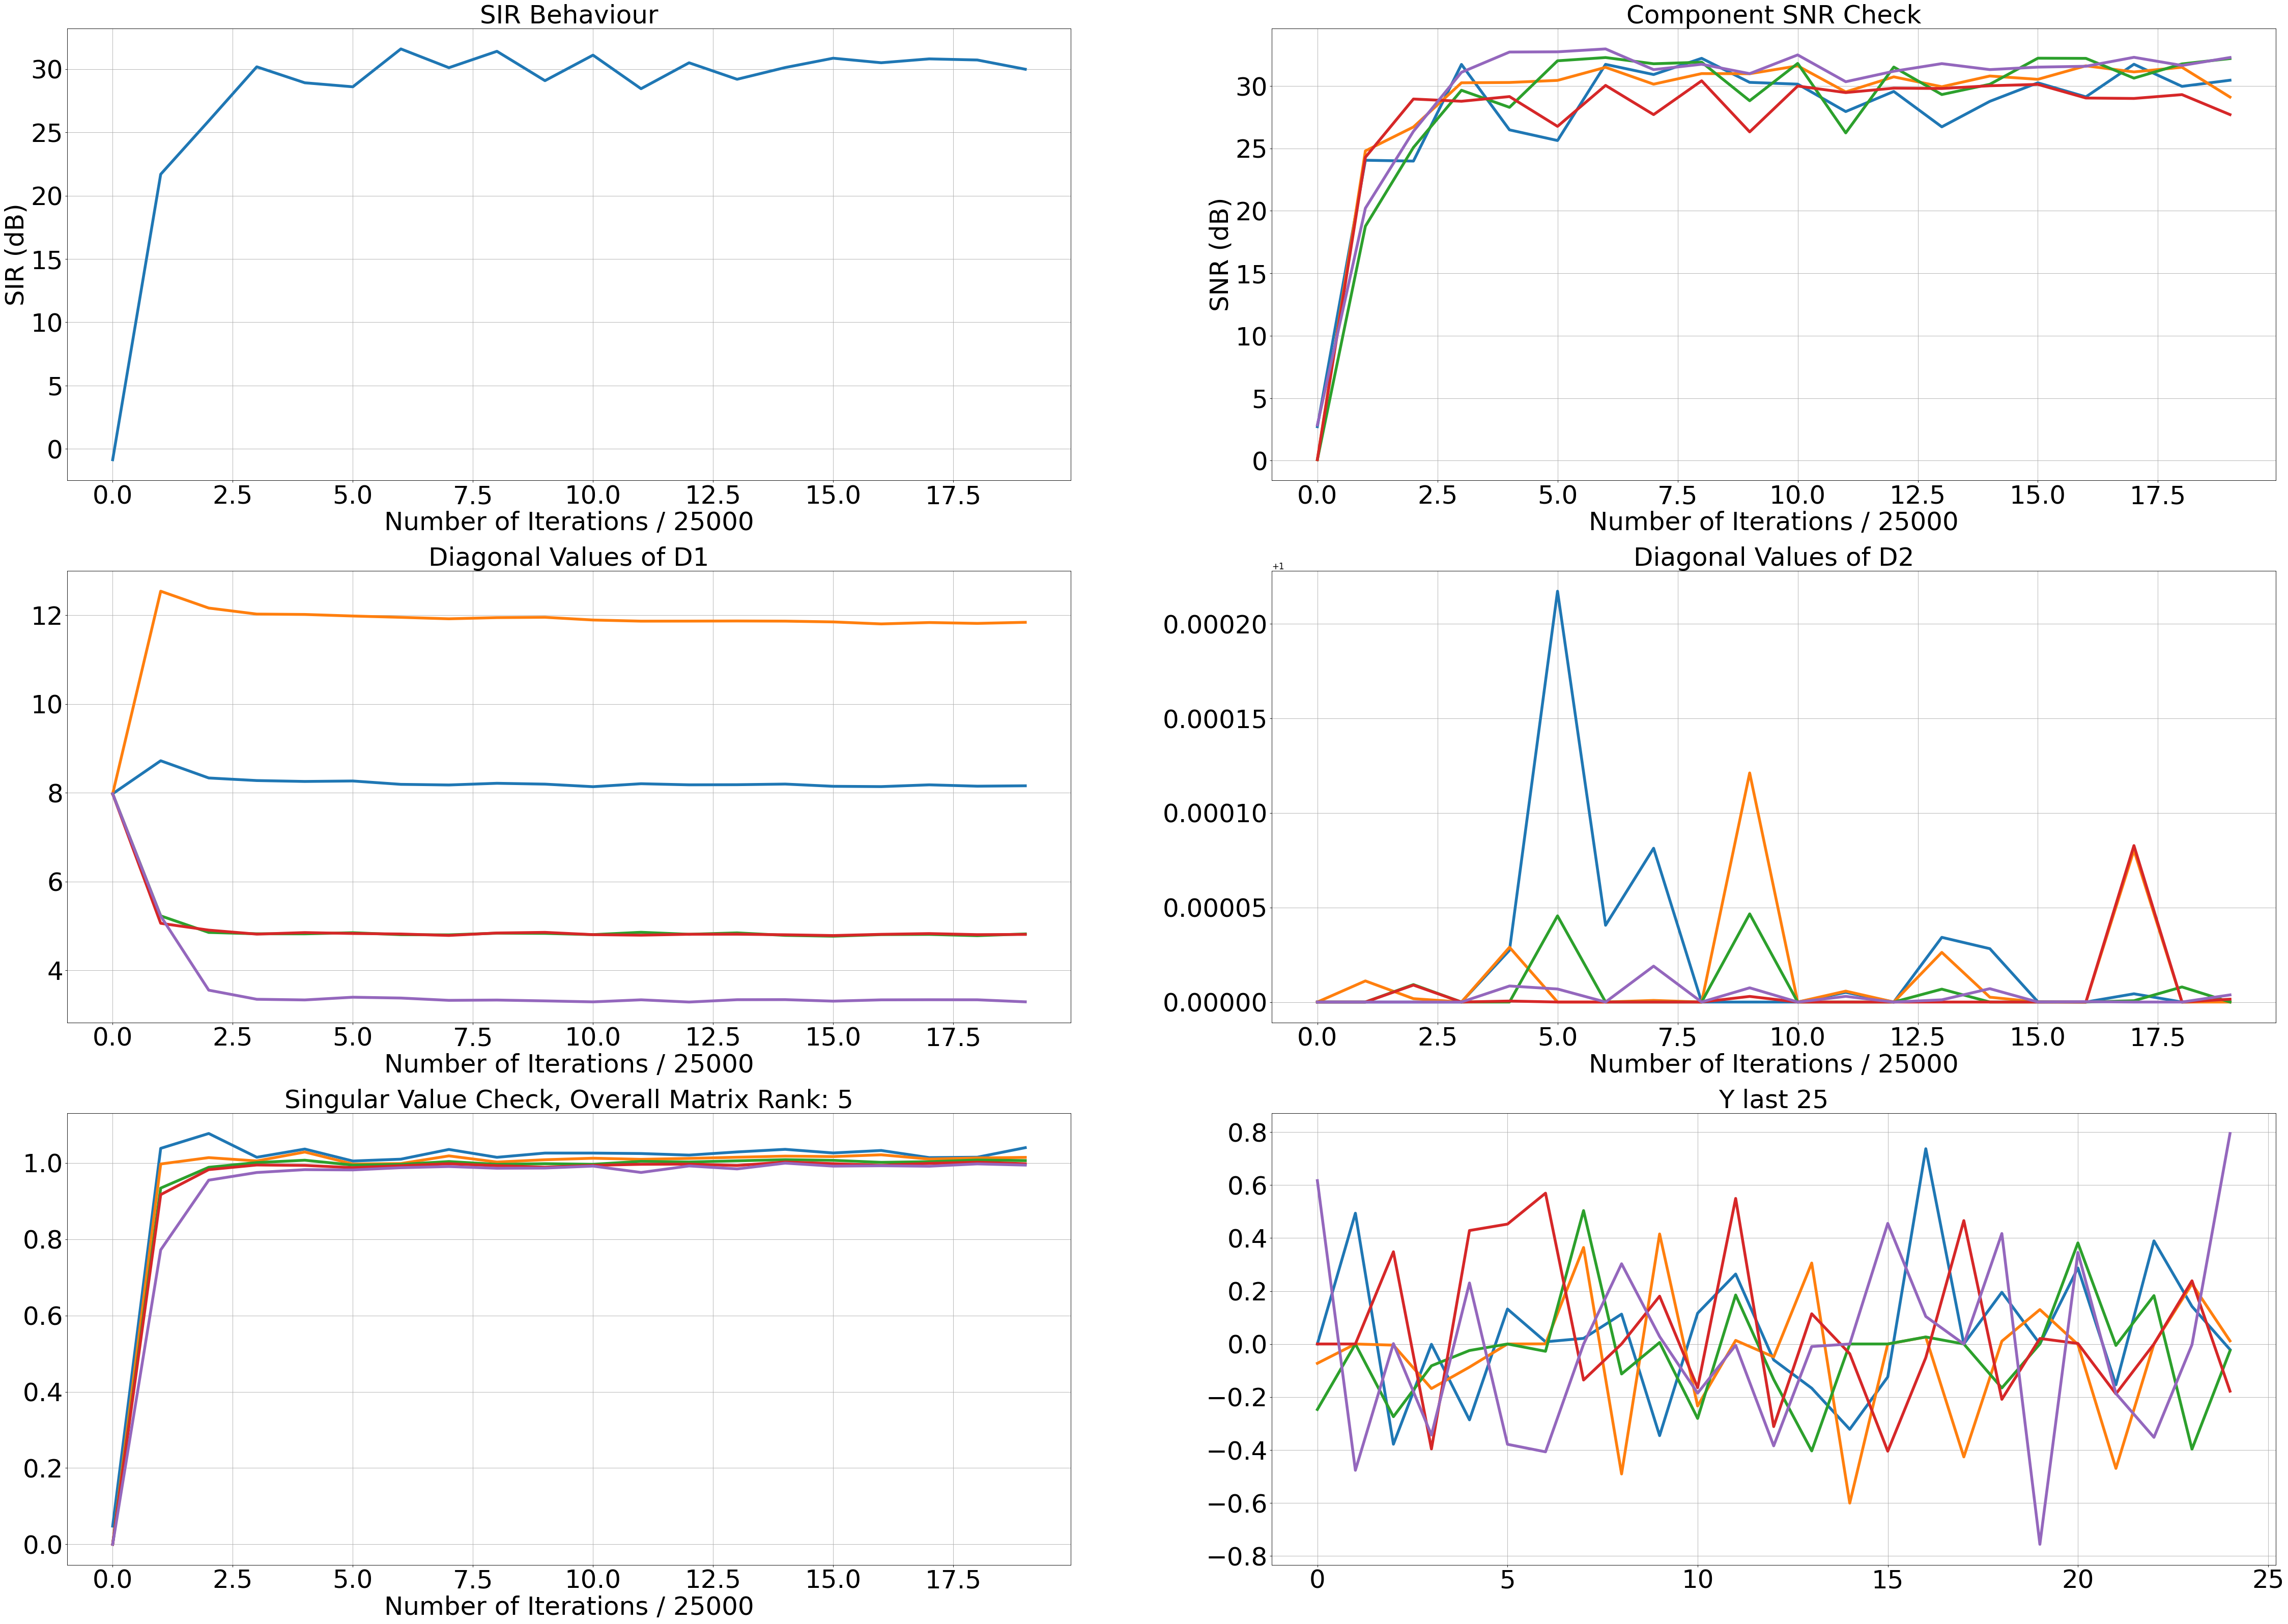

100%|██████████| 500000/500000 [32:04<00:00, 259.81it/s]


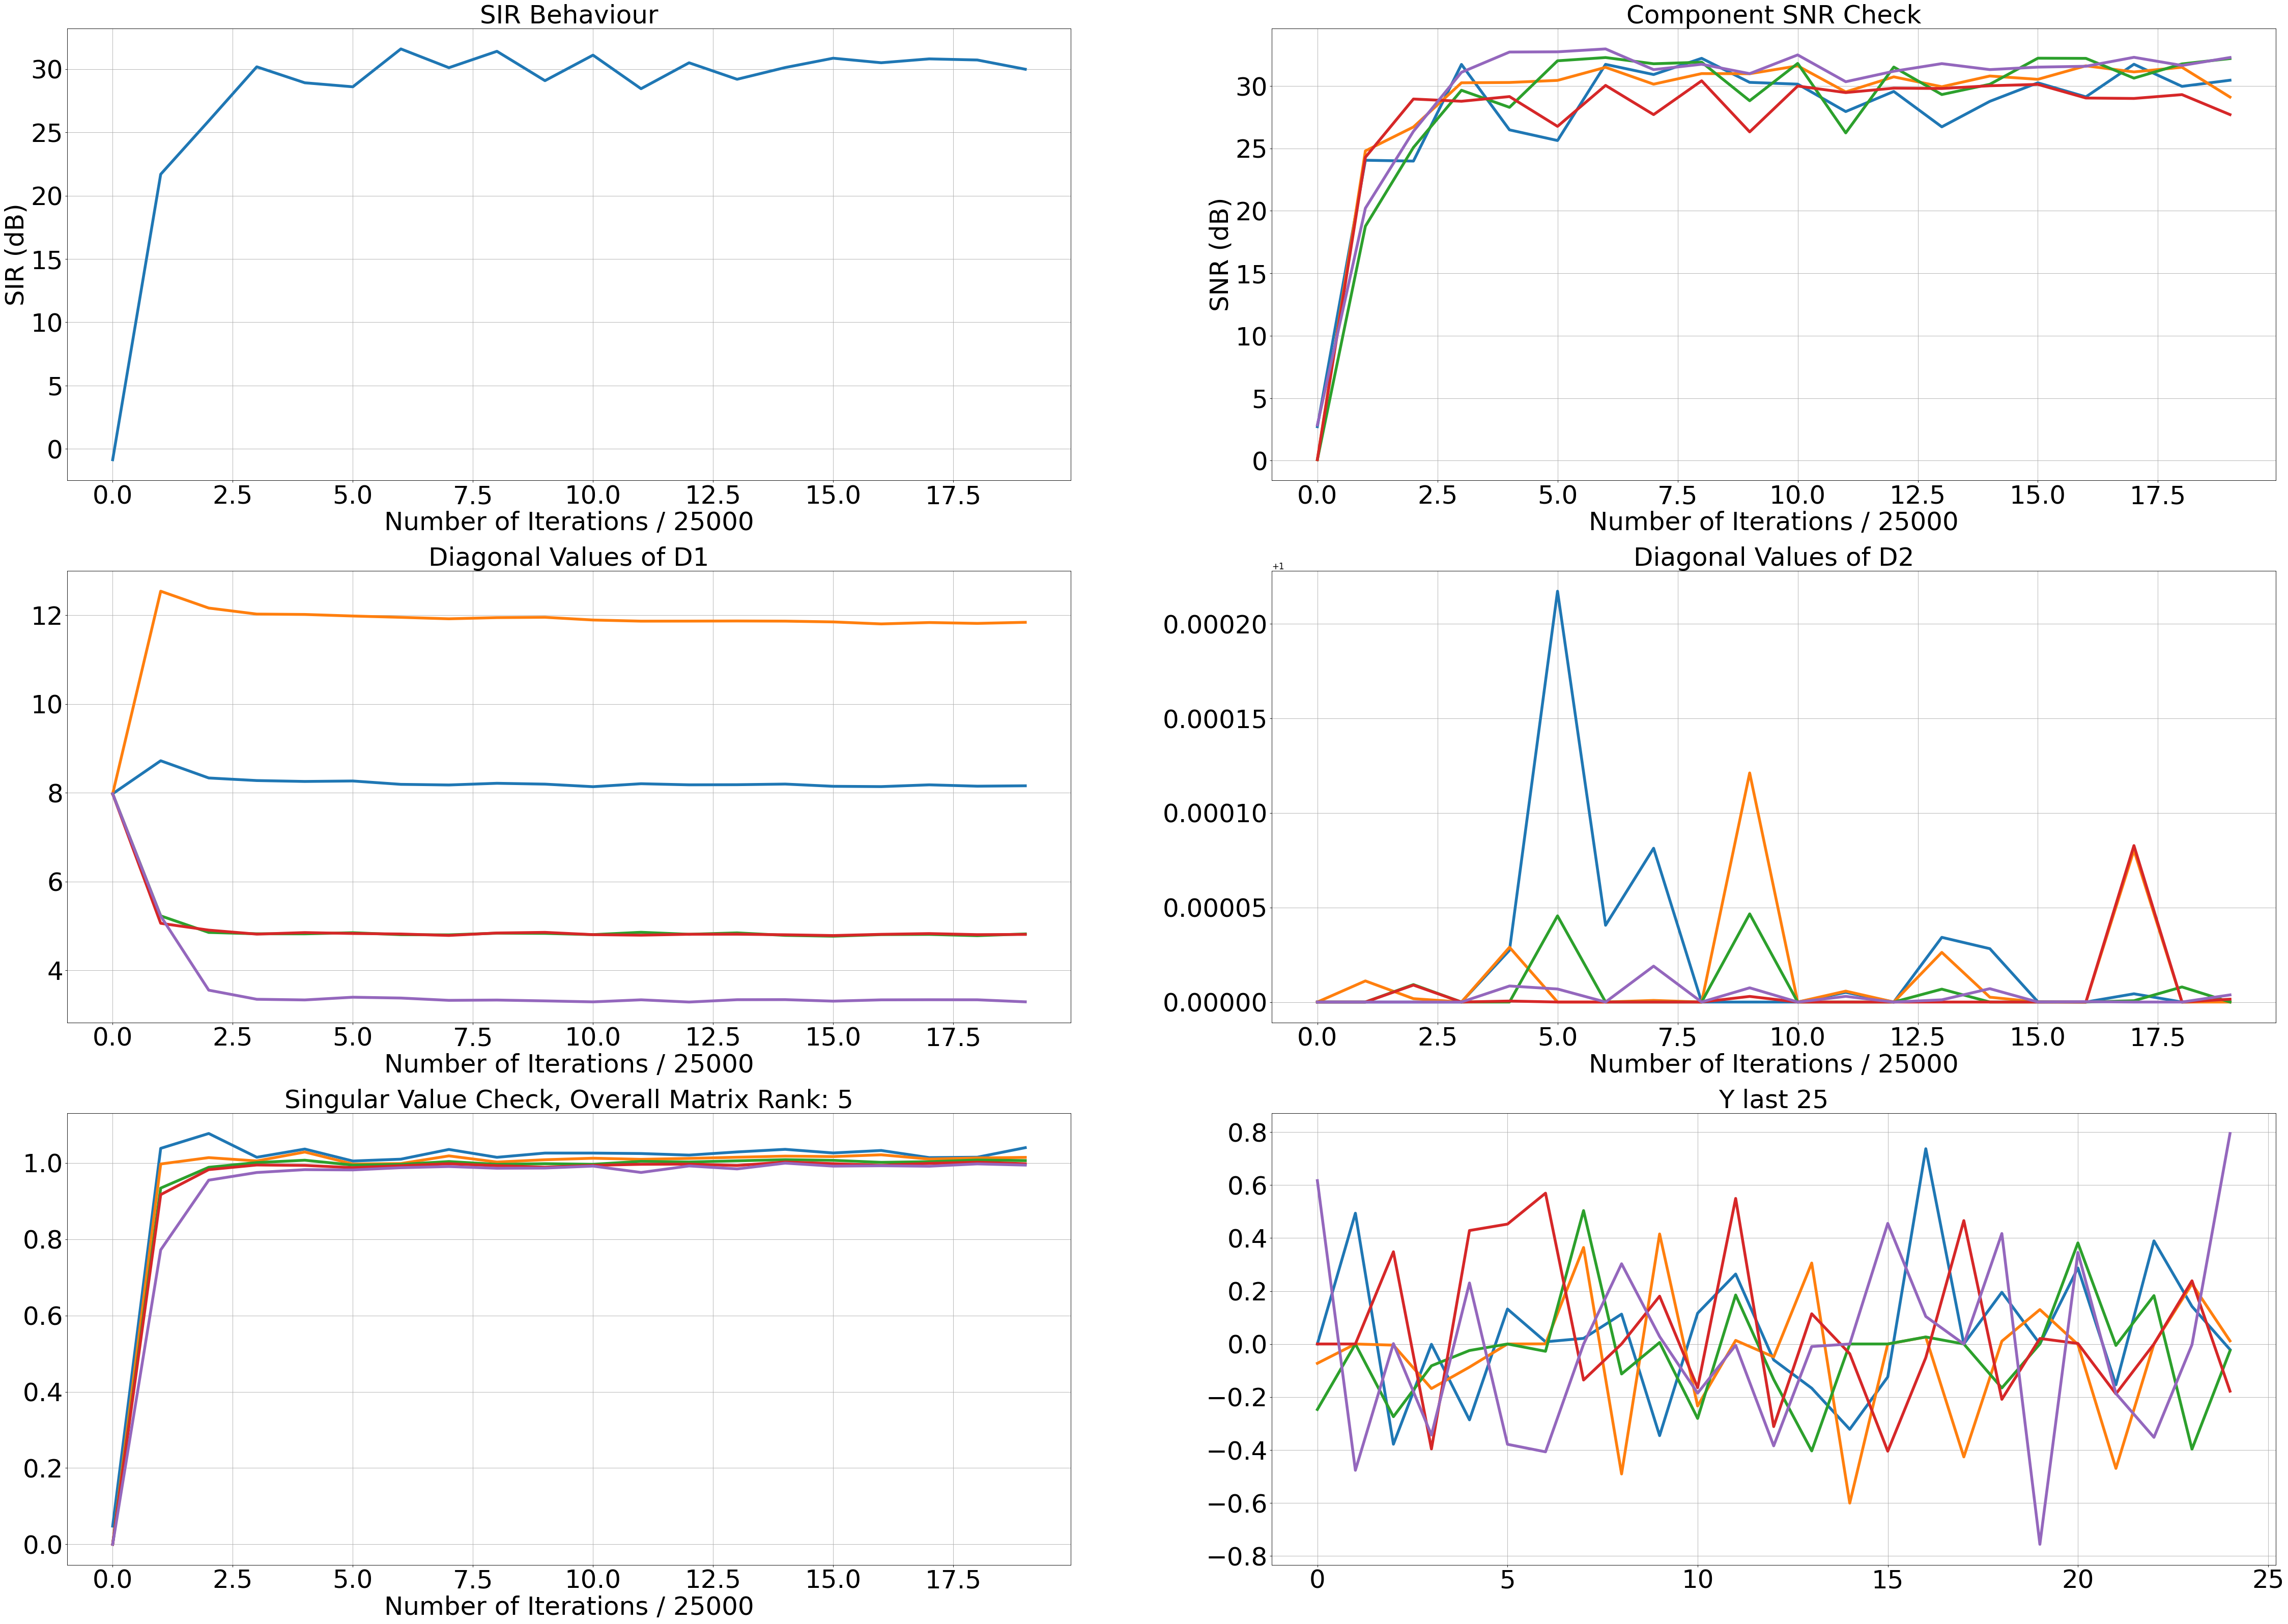

In [6]:
debug_iteration_point = 25000
modelWSM = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                        gammaM_start = gammaM_start, gammaM_stop = gammaM_stop, 
                        gammaW_start = gammaW_start, gammaW_stop = gammaW_stop,
                        beta = beta, zeta = zeta, 
                        muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                        DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                        LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                        set_ground_truth = True, S = S, A = A)

modelWSM.fit_batch_sparse(X, n_epochs = 1, 
                          neural_lr_start = 0.4,
                          synaptic_lr_rule = synaptic_lr_rule,
                          neural_loop_lr_rule = neural_loop_lr_rule,
                          mixtures_power_normalized = mixtures_power_normalized,
                          debug_iteration_point = debug_iteration_point,
                          plot_in_jupyter = True,
                         )

# Visualize SNR Convergence of Each Source Component

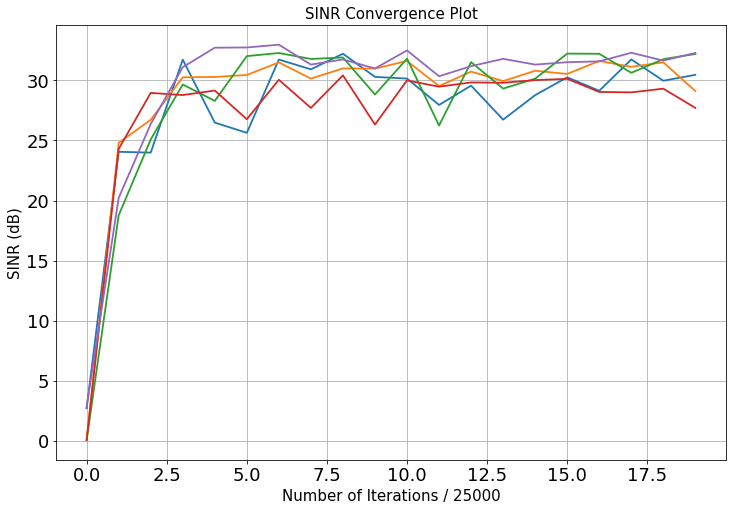

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(modelWSM.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10*np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [29.82827905 31.40885531 29.92142658 29.71769261 31.10835025]

Overall SINR : 30.336211814881185


# Vizualize Extracted Signals Compared to Original Sources

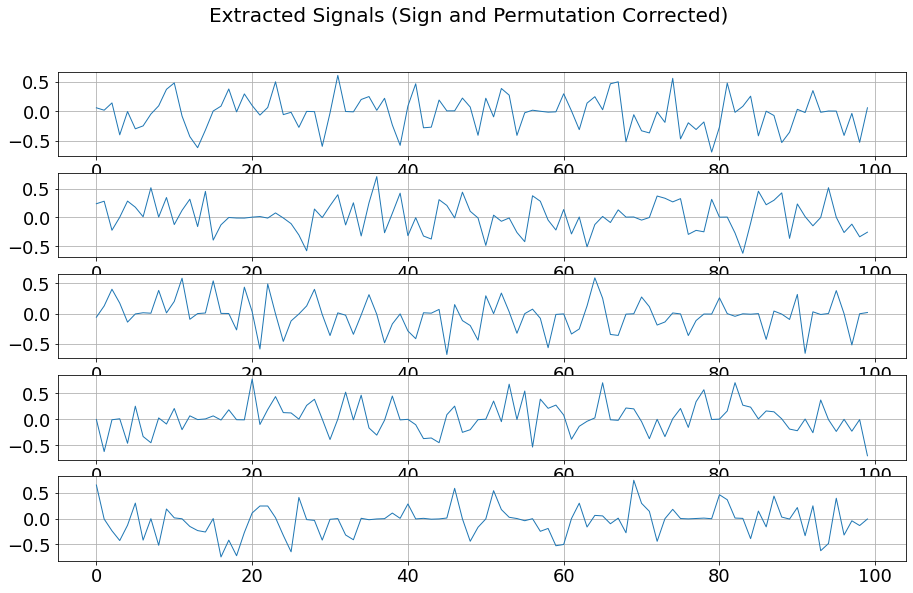

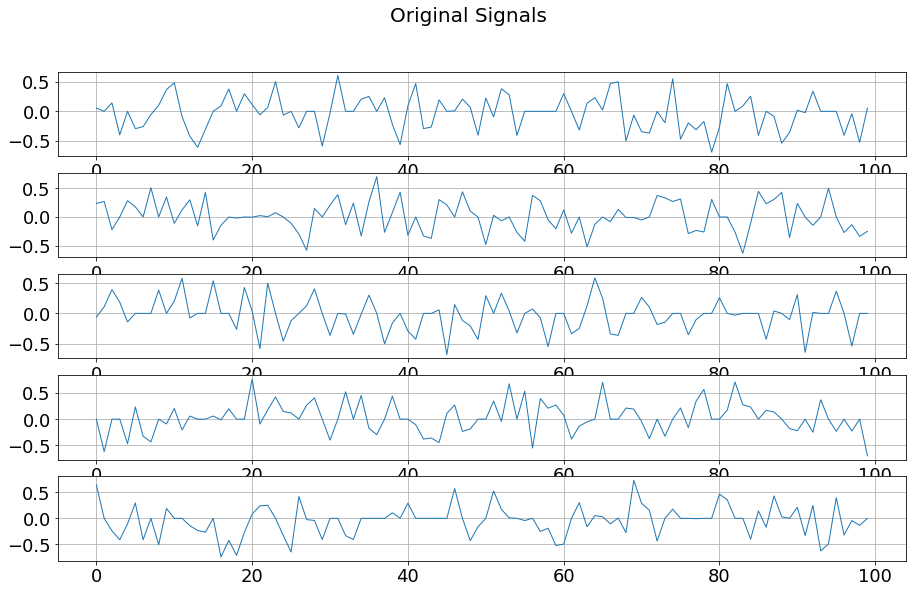

In [9]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)